In [1]:
import numpy as np
from lookup_table import CaseNum2EdgeOffset, getCaseNum
import trimesh
import os
import time

In [43]:
def marching_cube(thres,cells):
    # vertices use dictionary to avoid duplicate axes
    vertex_array = {}
    face_array = []
    t1 = time.time()
    # -------------------TODO------------------ 
    # compute vertices and faces
    # vertices: [N, 3]
    # faces: [M, 3], e.g. np.array([[0,1,2]]) means a triangle composed of vertices[0], vertices[1] and vertices[2]
    # for-loop is allowed to reduce difficulty
    # -------------------TODO------------------ 
    h,w,d = cells.shape
    global CaseNum2EdgeOffset
    CaseNum2EdgeOffset = np.array(CaseNum2EdgeOffset)
    for x in range(h-1):
        for y in range(w-1):
            for z in range(d-1):
                case_num = getCaseNum(x,y,z,thres,cells)
                
                base_point = np.array([x,y,z])
                edge_vertice1 = base_point[np.newaxis, :] + CaseNum2EdgeOffset[case_num, :3]
                edge_vertice2 = base_point[np.newaxis, :] + CaseNum2EdgeOffset[case_num, 3:]
                sdf1 = cells[edge_vertice1[:, 0], edge_vertice1[:, 1], edge_vertice1[:, 2]][:, np.newaxis]
                sdf2 = cells[edge_vertice2[:, 0], edge_vertice2[:, 1], edge_vertice2[:, 2]][:, np.newaxis]
                # Do linear interpolation here. Below is an example of 1-D.
                # (·)--------(·)--------(·)
                #  a          c          b
                # (xb-xa)*f(c) = (xc-xa)*f(b) + (xb-xc)*f(a)
                # => (f(b)-f(a))*xc = (xb-xa)*f(c) + xa*f(b) -xb*f(a)
                # and f(c) = thres.
                equal = np.where(sdf1==sdf2)
                not_equal = np.where(sdf1!=sdf2)[0]
                point_interpolated = ((edge_vertice2 - edge_vertice1) * thres + edge_vertice1*sdf2 - edge_vertice2*sdf1) 
                point_interpolated = point_interpolated[not_equal]
                point_interpolated /= (sdf2[not_equal]-sdf1[not_equal])
                cnt = 0 # to create face with 3 consecutive interaction points.
                add = []
                for pt in point_interpolated:
                    pt_ = tuple(pt)
                    if pt_ not in vertex_array:
                        l = len(vertex_array)
                        vertex_array[pt_] = l
                        cnt += 1
                        add.append(l)
                    else:
                        l = vertex_array[pt_]
                        if l not in add:
                            cnt += 1
                            add.append(l)
                    
                    if cnt == 3:
                        cnt = 0
                        face_array.append(add)
                        add = []
                        
    t2 = time.time()
    print("\nTime taken by algorithm\n"+'-'*40+"\n{} s".format(t2-t1))
    vertex_array = [list(x) for x in list(vertex_array.keys())]
    return np.array(vertex_array), np.array(face_array)

In [44]:
# reconstruct these two animals
shape_name_lst = ['spot', 'bob']
for shape_name in shape_name_lst:
    data = np.load(os.path.join('data', shape_name + '_cell.npy'))
    verts, faces = marching_cube(0, data)
    mesh = trimesh.Trimesh(vertices=verts, faces=faces)
    mesh_txt = trimesh.exchange.obj.export_obj(mesh)
    with open(os.path.join('../results', shape_name + '.obj'),"w") as fp:
        fp.write(mesh_txt)


Time taken by algorithm
----------------------------------------
24.839022636413574 s

Time taken by algorithm
----------------------------------------
26.027291774749756 s


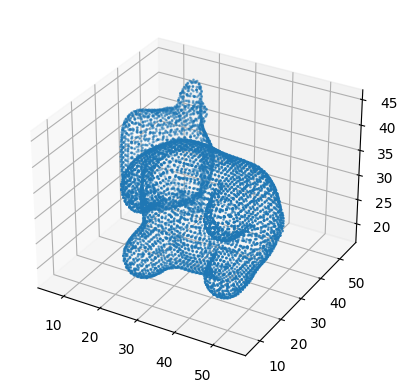

In [46]:
obj_path = '../results/spot.obj'
mesh = trimesh.load(obj_path)
verts = mesh.vertices
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')
ax.scatter3D(verts[:,0], verts[:,1], verts[:,2], s=1)